In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime

import json
import pickle

# Our generated code
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%load_ext autoreload
%autoreload 2
    
import libs.exploring as explore
import libs.visualising as visualize
import libs.cleansing as cleanse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Explore raw data

Packages I had to install:
    - pip install pyspark_dist_explore
    - pip install plotly
and then restart the Kernel.

In [52]:
# Import data
open_food_facts_csv_file = "./data/en.openfoodfacts.org.products.csv"

# Load list of columns (external file) that are loaded into pyspark
data = []
with open("columns_to_import.txt", "r") as json_data:
    columns_to_import = json.load(json_data)
    columns_to_import


food_facts_pd = pd.read_csv(open_food_facts_csv_file,
                            delimiter="\t",
                            usecols=columns_to_import.keys(),
                            dtype=columns_to_import,
                            index_col='code')

In [61]:
pd.to_datetime(food_facts_pd.created_datetime,format="yyyy-MM-dd'T'HH:mm:ssZ")

ValueError: time data '2016-09-17T09:17:46Z' does not match format "yyyy-MM-dd'T'HH:mm:ssZ" (match)

#### Find NaN columns

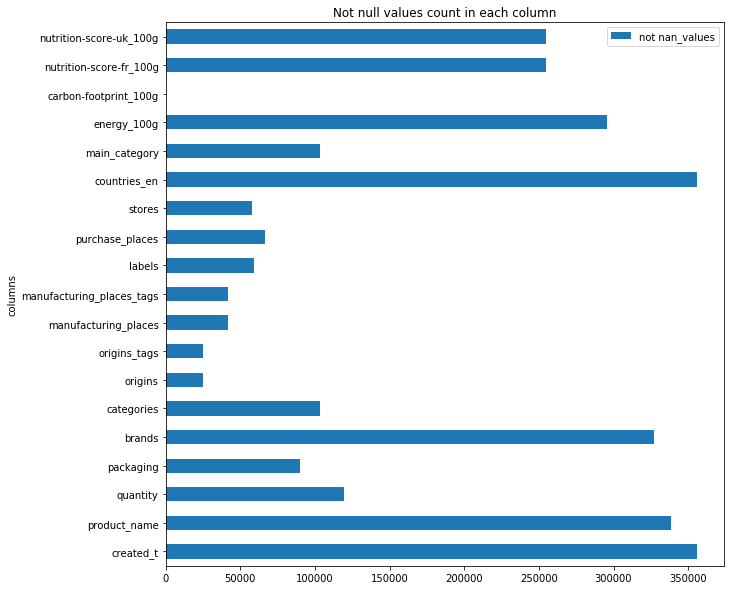

In [28]:
null_entries = pd.DataFrame({'columns' : food_facts_pd.columns,
                             'not nan_values' : [food_facts_pd[c].count() for c in food_facts_pd]
                            })

# Plot NaNs counts
null_entries.set_index('columns').plot(kind='barh', figsize=(10, 10))
plt.title("Not null values count in each column")
plt.show()

This number is way too low. We need to find a way to deal with incomplete data or a way to complete it.

# Data cleansing
Guys, the country tags in this dataset are a mess. They differ in language, typesetting, everything. I am trying to clean them up, but I could not find an automated way to assign the correct country tags. 
This is why I've started a list with correct mappings in the countries_replacement.json file, which is still incomplete and I need your help to complete this list. Take a look at it, I think it is self-explaining.

### Unitize tags


In [30]:
food_facts_pd = food_facts_pd.dropna(subset=['product_name', 'countries_en', 'stores'])

In [31]:
food_facts_pd = food_facts_pd.fillna("")
food_facts_pd

,created_t,product_name,quantity,packaging,brands,categories,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,purchase_places,stores,countries_en,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,,,
0000000290616,1484605978,Salade Cesar,0.980 kg,Frais,Kirkland Signature,Légumes-feuilles,Québec,quebec,Brossard Québec,brossard-quebec,,,Costco,Canada,en:plant-based-foods-and-beverages,1210,,6,6
0000000394710,1484497370,Danoises à la cannelle roulées,1.150 kg,Frais,Kirkland Signature,"Snacks sucrés,Biscuits et gâteaux,Pâtisseries",Québec,quebec,Brossard Québec,brossard-quebec,,Brossard Québec,Costco,Canada,en:sugary-snacks,1520,,,
0000001071894,1409411252,Flute,,"Paper,plastic film",Waitrose,"Plant-based foods and beverages,Plant-based fo...",France,france,United Kingdom,united-kingdom,,"Brent,UK",Waitrose,United Kingdom,en:plant-based-foods-and-beverages,,,,
0000001938067,1484501528,Chaussons tressés aux pommes,1.200 kg,Frais,Kirkland Signature,"Snacks sucrés,Biscuits et gâteaux,Pâtisseries",Québec,quebec,Brossard Québec,brossard-quebec,,Brossard Québec,Costco,Canada,en:sugary-snacks,1090,,9,9
0000004302544,1488464896,Pain Burger Artisan,1.008 kg / 12 pain,"Frais,plastique",Kirkland Signature,Boulange,Québec,quebec,"Brossard,Québec","brossard,quebec",,"Brossard,Québec",Costco,Canada,fr:boulange,1160,,1,1
0000008237798,1491943307,Quiche Lorraine,1 400 kg,Frai,Kirkland Signature,Quiches lorraines,Québec,quebec,"Brossard,Québec","brossard,quebec",,"Brossard,Québec",Costco,Canada,en:meals,478,,2,2
0000008240095,1484342673,Pâté au poulet,1250 kg,Frais,Kirkland Signature,Poulets cuisinés,Québec,quebec,Brossard Québec,brossard-quebec,,Brossard Québec,Costco,Canada,en:meats,751,,,
0000010090206,1370977431,Thé de Noël aromatisé orange-cannelle,75 g,aluminium,Alice Délice,"Aliments et boissons à base de végétaux,Boisso...",,,France,france,,"Lyon,France",Alice Délice,France,en:beverages,,,,
0000010127735,1462616704,Sirops pour ganache macarons,4 x 5 cl,"Carton,Bouteille,Verre",Alice Délice,"Sirops,Sirops pour ganache",,,,,,"Lyon,France",Alice Délice,France,en:syrups,,,,


Note :  
- purchase_places and countries_en are the same though "countries_en" is more complete
-  manufacturing_places and origins are different

In [32]:
countries = pd.read_csv("./data/country_lookup.csv")[['name', 'cca2', 'alias', 'Forced']]

In [33]:
#example
copy_purchases_places = food_facts_pd[['purchase_places']].iloc[:100, :]
copy_purchases_places = copy_purchases_places.replace('', "Unknown", regex=True)
copy_purchases_places['Filtered'] = copy_purchases_places.purchase_places.apply(lambda x: cleanse.country_name_filter(x, countries))
copy_purchases_places

,purchase_places,Filtered
code,,
0000000290616,Unknown,[Unknown]
0000000394710,Brossard Québec,[Unknown]
0000001071894,"Brent,UK","[Unknown, United Kingdom]"
0000001938067,Brossard Québec,[Unknown]
0000004302544,"Brossard,Québec","[Unknown, Canada]"
0000008237798,"Brossard,Québec","[Unknown, Canada]"
0000008240095,Brossard Québec,[Unknown]
0000010090206,"Lyon,France","[Unknown, France]"
0000010127735,"Lyon,France","[Unknown, France]"


In [10]:
# Unitze labels
with open('taxonomies.json', 'r') as json_data:
    labels_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.labels = food_facts_pd.labels.apply(lambda x: [labels_lookup[z] for z in x.split(',')])

In [11]:
# Store labels
with open('stores_lookup.json', 'r') as json_data:
    stores_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.stores = food_facts_pd.stores.fillna("").apply(lambda x: [stores_lookup[z] for z in x.split(',')])

In [12]:
food_facts_pd

,created_t,product_name,quantity,packaging,brands,categories,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,purchase_places,stores,countries_en,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,,,
0000000290616,1484605978,Salade Cesar,0.980 kg,Frais,Kirkland Signature,Légumes-feuilles,Québec,quebec,Brossard Québec,brossard-quebec,[],,[Costco],Canada,en:plant-based-foods-and-beverages,1210,,6,6
0000000394710,1484497370,Danoises à la cannelle roulées,1.150 kg,Frais,Kirkland Signature,"Snacks sucrés,Biscuits et gâteaux,Pâtisseries",Québec,quebec,Brossard Québec,brossard-quebec,[],Brossard Québec,[Costco],Canada,en:sugary-snacks,1520,,,
0000001071894,1409411252,Flute,,"Paper,plastic film",Waitrose,"Plant-based foods and beverages,Plant-based fo...",France,france,United Kingdom,united-kingdom,[],"Brent,UK",[Waitrose],United Kingdom,en:plant-based-foods-and-beverages,,,,
0000001938067,1484501528,Chaussons tressés aux pommes,1.200 kg,Frais,Kirkland Signature,"Snacks sucrés,Biscuits et gâteaux,Pâtisseries",Québec,quebec,Brossard Québec,brossard-quebec,[],Brossard Québec,[Costco],Canada,en:sugary-snacks,1090,,9,9
0000004302544,1488464896,Pain Burger Artisan,1.008 kg / 12 pain,"Frais,plastique",Kirkland Signature,Boulange,Québec,quebec,"Brossard,Québec","brossard,quebec",[],"Brossard,Québec",[Costco],Canada,fr:boulange,1160,,1,1
0000008237798,1491943307,Quiche Lorraine,1 400 kg,Frai,Kirkland Signature,Quiches lorraines,Québec,quebec,"Brossard,Québec","brossard,quebec",[],"Brossard,Québec",[Costco],Canada,en:meals,478,,2,2
0000008240095,1484342673,Pâté au poulet,1250 kg,Frais,Kirkland Signature,Poulets cuisinés,Québec,quebec,Brossard Québec,brossard-quebec,[],Brossard Québec,[Costco],Canada,en:meats,751,,,
0000010090206,1370977431,Thé de Noël aromatisé orange-cannelle,75 g,aluminium,Alice Délice,"Aliments et boissons à base de végétaux,Boisso...",,,France,france,[],"Lyon,France",[Alice Délice],France,en:beverages,,,,
0000010127735,1462616704,Sirops pour ganache macarons,4 x 5 cl,"Carton,Bouteille,Verre",Alice Délice,"Sirops,Sirops pour ganache",,,,,[],"Lyon,France",[Alice Délice],France,en:syrups,,,,


In [13]:
# Generate a dataframe that extracts all information required by the web crawler
if 1==0: # skip cell
    products = food_facts_pd

    products.to_pickle("./web_crawler/products_pd.pickle")
    

# Analyse data

## Production / manufacture impact

### Global distribution of global food producers

#### Which are the dominant global food producers and manufacturers?

Where are those products bought?

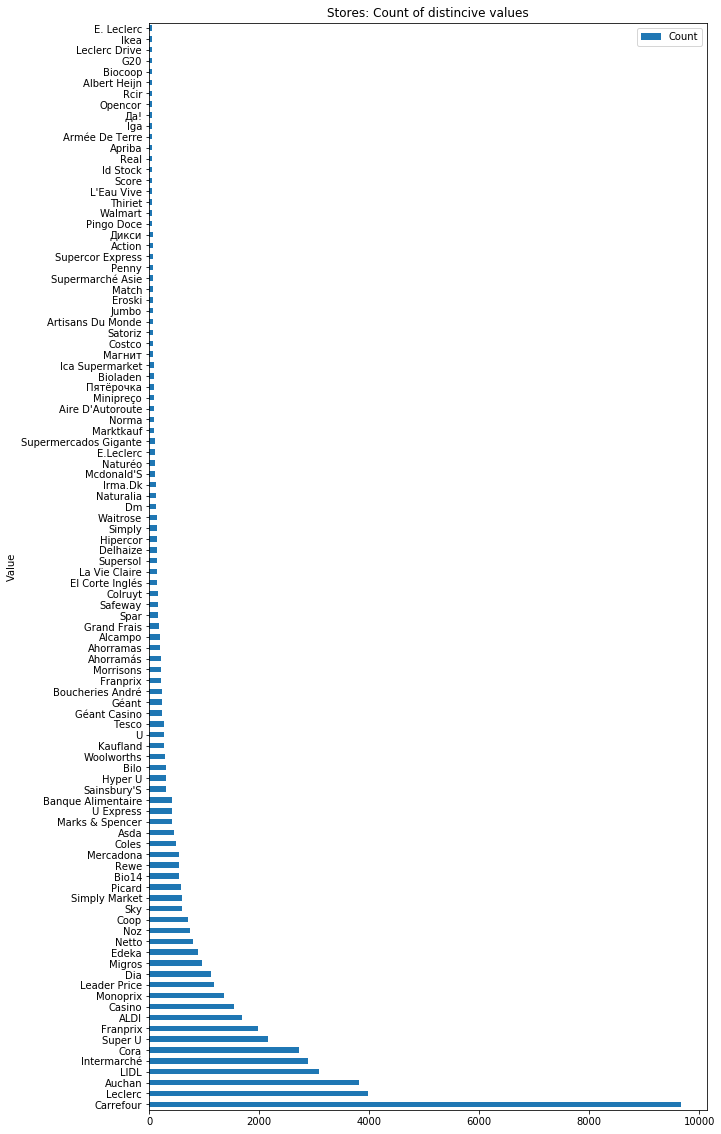

({"Aire D'Autoroute Du Jura Sur L'A39",
  'Kusmi Tea',
  'Higher Living',
  'Italian Caffè',
  'D&S',
  'Weltladen',
  ' Caprabo',
  'Simply Market - Aubervilliers',
  'Carrefour Lingostière',
  'Stuttart',
  'Eurasie Bordeaux',
  'Eurasie',
  'Biofield',
  'Supermarché - U Express Grand Rue Strasbourg',
  'Ipercoop',
  'The Dutch Shop Llc',
  'Leclerc ',
  'Supermarché De Blois',
  'G.Detou',
  'Doma Frais',
  'Unide',
  'Platform 9 & 3/4',
  'Diego Llorca E Hijos',
  'Asian Stores',
  'Marks&Spencer',
  "Aire D'Autoroute",
  'Festival Foods',
  'Dm',
  'Mère Poulard',
  'La Biscuiterie De Bretagne',
  'Raiponce F84300 Cavaillon',
  'Https://Www.Naturoghelse.Dk/Shop/Chufa-Glutenfri-400-10192P.Html',
  'Ld',
  'Ninety Nine Restaurant',
  'Pharmacie',
  'Leader Pice',
  'Caméléon',
  'Tang',
  'Ocady Plus',
  'Toutpargel',
  'Eleclerc',
  ' En:Packaging-Completed',
  'Lindt',
  'Maximo',
  'Epicerie Bio',
  'Citydia',
  'Asia',
  'Métro',
  'Macdan',
  'Casa Ametller',
  'Carrefourmarke

In [14]:
# Plot distribution of stores where items were bought
visualize.plot_occurences_of_distinct_values(food_facts_pd, 'stores')

#### How is this distribution impacted when we consider neutral and large carbon footprint products? 

In [ ]:
#dataset carbon footprint coming from Eaternity

### Case study: Palm oil

#### Can we observe any trend in the number of products including this oil (assuming a strong dependence between date the product was added to the database and data the product was invented)?

In [35]:
#extraction products with palm oil
food_facts_pd[food_facts_pd.categories.str.contains("palm")]


,created_t,product_name,quantity,packaging,brands,categories,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,purchase_places,stores,countries_en,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,,,
2000000030313,1460923672,Nocciolata,,"bocal,verre",rigoni di asiago,"Petit-déjeuners,Produits à tartiner,Produits à...",,,,,"Bio,AB",,Carrefour,France,en:spreads,,,,
26043951,1375780239,Cœurs de palmiers,220g,Conserve,Fleurs des champs,"Aliments et boissons à base de végétaux,Alimen...",,,Équateur,equateur,,,Aldi,France,en:plant-based-foods-and-beverages,114,,2,2
3017760030106,1381688720,Palmito L'original,100g,"Boîte,Carton","Lu,Kraft foods","en:sugary-snacks, en:biscuits-and-cakes, en:bi...",,,,,,"Saint Etienne de Montluc,France",Super U,France,en:sugary-snacks,2280,,23,23
3017800209400,1425121501,Coeurs de palmiers tendres,Poids net total 400 g. Poids net égoutté 220 g,"Conserve,boite métallique 1/2",D'Aucy,"Aliments et boissons à base de végétaux,Alimen...",Equateur,equateur,,,"Récoltés à la main,Point Vert","France,Dax,Montargis","Leclerc,Géant",France,en:plant-based-foods-and-beverages,129,,0,0
3229820021003,1378575997,Palmiers Bio,100 g,"carton,sachet plastique individuel",Bjorg,"en:sugary-snacks, en:biscuits-and-cakes, en:de...",,,France,france,"en:ecocert, en:organic",france,Monoprix,France,en:sugary-snacks,2197,,20,20
3245411878863,1399909863,Coeurs de palmiers sauvages bio,400 g (250 g égoutté),"bocal verre,couvercle métal",Carrefour,Coeurs de palmier en conserve,Colombie,colombie,,,"Bio,Bio européen,AB Agriculture Biologique,CO-...",France,Carrefour,France,en:plant-based-foods-and-beverages,92,,0,0
3250390664888,1373443001,Coeurs de Palmiers,400 g,Conserve,Saint Eloi,"Aliments et boissons à base de végétaux,Alimen...","Equateur,Costa Rica","equateur,costa-rica",,,Cueillis à la Main,"Amplepuis,France",Intermarché,France,en:plant-based-foods-and-beverages,136,,-1,-1
3250391723072,1473800324,Coeurs de palmiers,400 g,"conserve,métal",Netto,"Aliments et boissons à base de végétaux,Alimen...",,,,,,France,Netto,France,en:plant-based-foods-and-beverages,138,,1,1
3254473047001,1338492777,Cœurs de palmiers,220 g,conserve,"Géant vert,Général Mills","Aliments et boissons à base de végétaux,Alimen...","Equateur,Costa Rica","equateur,costa-rica",,,Cueilli à la main,Marseille 5°,Super U,France,en:plant-based-foods-and-beverages,130,,3,3


Looking at the dataset, we have to find a way to differenciate palm than palm oil according to the associated words in "categories". It seems that "Produit à tartiner" goes with palm oil but there are other products like "coeur de palmier" that have nothing to do with palm oil. 

    Solutions :
    -word2vec

#### Which country use palm oils for production?

## Good nutrition impact

### High-nutrional products

#### Has there been a surge in high graded Products in the UK / France over the past years?

In [47]:
nutrition_fr = food_facts_pd[['created_t','nutrition-score-fr_100g']]
nutrition_fr.dropna()

,created_t,nutrition-score-fr_100g
code,,
0000000290616,1484605978,6
0000000394710,1484497370,
0000001071894,1409411252,
0000001938067,1484501528,9
0000004302544,1488464896,1
0000008237798,1491943307,2
0000008240095,1484342673,
0000010090206,1370977431,
0000010127735,1462616704,


#### What are those products made of?
What is the composition? Do they contain many additives?  Where are these products sold? 

#### Where do these product come from and where are they manufactured?

#### Where are those products sold?

### Carbon footprint of nutrionally-high graded products
Common sense would suggest most nutritionally-high graded products are organic (plant, fruit, vegetables, …) and are therefore not manufactured, thus having a small footprint.

#### Are expansive and polluting products performing more poorly in the nutrition mark?

#### Can we establish a meaningful correlation between these product and the carbon footprint  or an estimated price (using another dataset or creating our own with web scraping)? 

ValueError: could not convert string to float: 

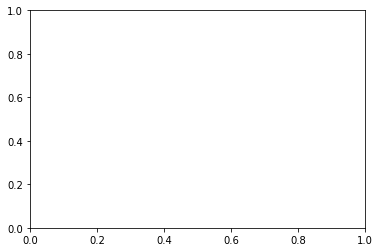

In [16]:
# Plot carbon foot-print histogram over calories# 
fig, ax = plt.subplots()

food_facts_pd['energy_100g'] = food_facts_pd['energy_100g'].astype('float')
food_facts_pd['carbon-footprint_100g'] = food_facts_pd['carbon-footprint_100g'].astype('float')

food_facts_pd.plot.scatter(x='energy_100g', 
                           y='carbon-footprint_100g', 
                           c='carbon-footprint_100g', 
                           colormap='coolwarm',
                           ax=ax)
ax.set_facecolor('black')

plt.xlabel('Energy per 100g [kcal]')
plt.show()

TypeError: 0.0 is not a string

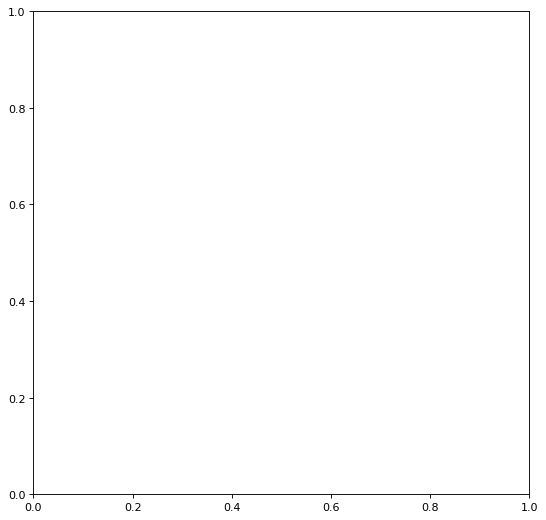

In [17]:
# Food calories over carbon-foot print
visualize.plot_cluster_by_tags(df=food_facts_pd.dropna(subset=['labels']),
                                 plot2D_features = ["carbon-footprint_100g", "energy_100g"],
                                 cluster="labels")

#### Is there a general correlation between high carbon footprint and price? 

### Plot distribution of availability of products in countries

In [18]:
# Find all distinct countries
countries_set = set()
for index, row in food_facts_pd.iterrows():
    for country in row.countries_en:
        countries_set.add(country)

# Count the number of time each country appear in the dataframe
country_count = dict()
for country in list(countries_set):
    country_count[country] = food_facts_pd.countries_en.apply({country}.issubset).sum()

In [19]:
country_count_pd = pd.DataFrame(list(country_count.items()), columns=['Country', 'Value'])
country_count_pd['Country'] = country_count_pd['Country'].str.upper()
country_count_pd

,Country,Value
0,R,661
1,T,57
2,港,1
3,Y,4297
4,A,54751
5,L,5203
6,D,6071
7,Ô,4
8,W,2
9,Q,25


In [ ]:
import folium

## Country coordinates for plotting
country_geo = './data/world-countries.json'

map = folium.Map(location=[0, 0], tiles='Mapbox Bright', zoom_start=1.5)

# choropleth maps bind Pandas Data Frames and json geometries.
map.choropleth(geo_data=country_geo,
               data=country_count_pd,
               columns=['Country', 'Value'],
               fill_color='YlGnBu', 
               key_on='feature.id',
               fill_opacity=0.7, 
               line_opacity=0.2,
               )
map